## Note

This is updated version of the notebook and there is additional information complared to publication in Medium. Neverthelss, the conclusions are the same.

## Imports of packages and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
import statsmodels.tsa.arima_model as arima_model
from arch import arch_model
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [2]:
df = pd.read_csv('crypto_prices.csv', index_col='datetime', parse_dates=True)

In [3]:
display(df.shape)
display(df.head(10))
display(df.tail(10))

(3458, 4)

,doge_price,btc_price,eth_price,lite_price
datetime,,,,
2017-05-01 00:00:00+00:00,0.000745,1368.62,80.3855,16.1630
2017-05-01 12:00:00+00:00,0.000686,1421.60,76.2970,15.9177
2017-05-02 00:00:00+00:00,0.000573,1465.10,75.9496,15.4996
2017-05-02 12:00:00+00:00,0.000610,1452.82,77.2638,15.8950
2017-05-03 00:00:00+00:00,0.000657,1466.98,77.8287,17.5693
2017-05-03 12:00:00+00:00,0.000678,1490.09,79.7182,21.0426
2017-05-04 00:00:00+00:00,0.000724,1540.49,87.8099,21.7078
2017-05-04 12:00:00+00:00,0.000744,1537.67,96.9814,23.3936
2017-05-05 00:00:00+00:00,0.000887,1600.40,99.3776,26.5536


,doge_price,btc_price,eth_price,lite_price
datetime,,,,
2022-01-19 00:00:00+00:00,0.163924,42010.35161,3114.272770,136.656856
2022-01-19 12:00:00+00:00,0.162356,41744.32984,3095.825838,136.916706
2022-01-20 00:00:00+00:00,0.164984,42142.15371,3147.413035,138.022170
2022-01-20 12:00:00+00:00,0.155204,40680.41991,3001.120038,130.364999
2022-01-21 00:00:00+00:00,0.153606,38886.26402,2847.602636,124.725244
2022-01-21 12:00:00+00:00,0.142640,36457.31810,2557.931623,114.391868
2022-01-22 00:00:00+00:00,0.128382,35415.02752,2433.329911,105.643136
2022-01-22 12:00:00+00:00,0.132746,35036.94474,2404.481618,108.427867
2022-01-23 00:00:00+00:00,0.139013,35703.47617,2501.267646,110.042079


We have 12-hr data from 1.5.2017 to 23.1.2022.

## BITCOIN

### Data Exploration

In [4]:
df_btc = df['btc_price']
display(df_btc.isnull().sum())

0

As for bitcoin we are going to apply models of forecasting, data will be split to train and test set and exploration will be performedd on train set.

In [5]:
#Split to train and test sets
btc_train = df_btc[df_btc.index<'2021-07-01']
btc_test = df_btc[df_btc.index>='2021-07-01']
btc_train.shape, btc_test.shape

((3044,), (414,))

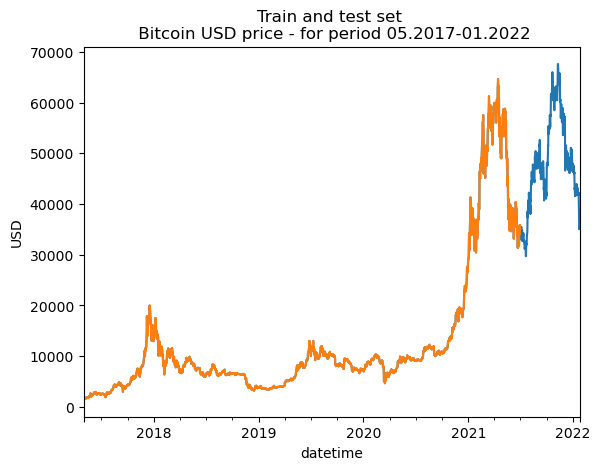

In [6]:
df_btc.plot()
plt.title('Train and test set \n Bitcoin USD price - for period 05.2017-01.2022')
plt.ylabel('USD')
btc_train.plot()
plt.show()

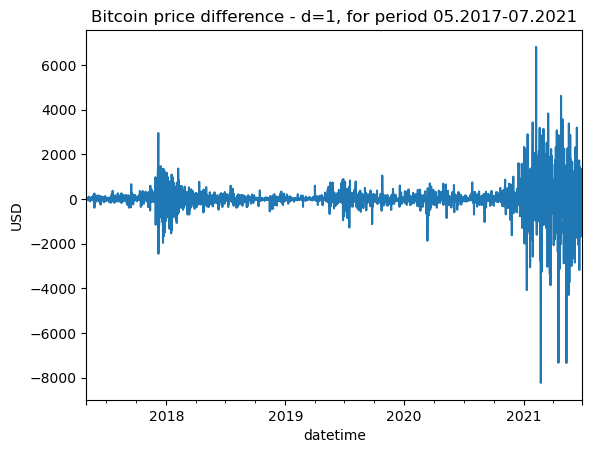

In [7]:
btc_train.diff().plot()
plt.title('Bitcoin price difference - d=1, for period 05.2017-07.2021')
plt.ylabel('USD')
plt.show()

In [8]:
btc_diff = btc_train.diff()
btc_diff = btc_diff.iloc[1:]
btc_diff.isnull().sum()

result = sm.tsa.stattools.adfuller(btc_train)
print('p-value of price: %f' % result[1])
result_diff = sm.tsa.stattools.adfuller(btc_diff)
print('p-value of 1 diff of price: %f' % result_diff[1])

p-value of price: 0.835859
p-value of 1 diff of price: 0.000000


Using the Augmented Dickey-Fuller test we proved that original data is with trend but first diff is stationary.

In [9]:
df_btc.idxmax(), btc_train.idxmax()

(Timestamp('2021-11-09 00:00:00+0000', tz='UTC'),
 Timestamp('2021-04-14 00:00:00+0000', tz='UTC'))

In [10]:
print(f'Bitcoin price increased by {round(df["btc_price"][-1]/df["btc_price"][1], 1)} times')

Bitcoin price increased by 24.7 times


Overall trend of prove increase especially from end of 2020, reaching its peak in 09-Nov-21 with some decrease till now. 

From May 2017 to Jan 2022 the price increased by 8.8 times.

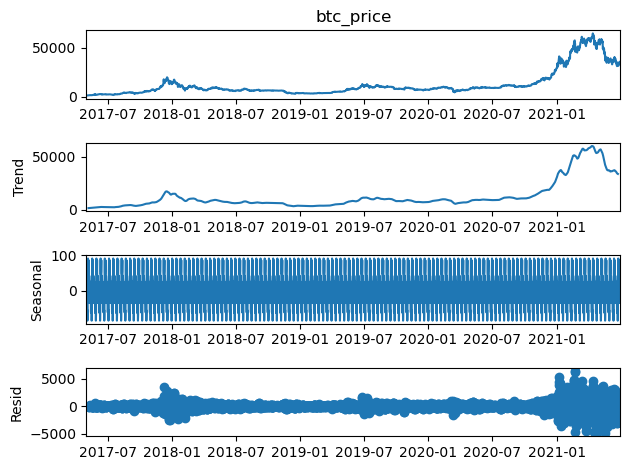

In [11]:
result = sm.tsa.stattools.adfuller(btc_train)
sm.tsa.seasonal_decompose(btc_train).plot()
plt.show()

Seasonal component is very small.

Due to large price differences in this time series we will use log(price) in the models.

In [12]:
btc_train_log =np.log(btc_train)
btc_test_log =np.log(btc_test)

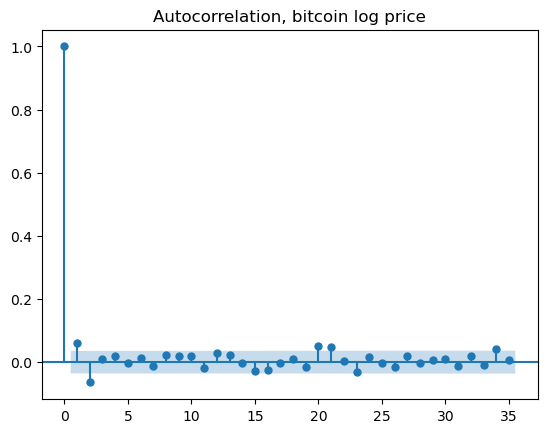

In [13]:
plot_acf(btc_train_log.diff().dropna())
plt.title('Autocorrelation, bitcoin log price')
plt.show()

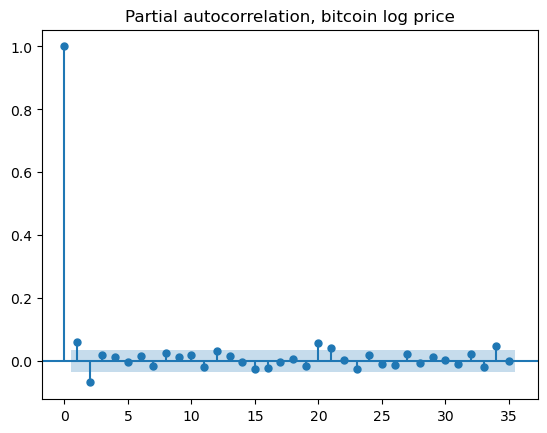

In [14]:
plot_pacf(btc_train_log.diff().dropna())
plt.title('Partial autocorrelation, bitcoin log price')
plt.show()

### Modeling

#### Beseline model for comparison

In [15]:
def create_random_walk(test_ser, train_ser):
    """
    Baseline function to make predictions based on previous pint values.
    takes test and train set and returns predictions list
    """
    pred_list=[]
    for i, data in enumerate(test_ser):
        if i == 0:
            pred_list.append(train_ser[-1])
        else:
            pred_list.append(test_ser[i-1])
    return pred_list

In [16]:
random_walk_btc = pd.Series(create_random_walk(btc_test_log, btc_train_log), index=btc_test_log.index, name='random_walk_pred')
RMSE = (((btc_test_log - random_walk_btc)**2).mean())**0.5

print('RMSE of baseline naive model for bitcoin is ', round(RMSE, 6))

RMSE of baseline naive model for bitcoin is  0.024847


#### ARIMA model

Rolling forecast

From autocorrelation and partial autocorrelation we chose parameters for ARIMA model of 1 and 2.

In [17]:
#List of hyperparameters testing for ARIMA model
p_list = [0, 1, 2]
q_list = [0, 1, 2]

In [18]:
for p in p_list:
    for q in q_list:
        history = btc_train_log.to_list()
        predictions = []
        for t in range(len(btc_test_log)):
            model = arima_model.ARIMA(history, order=(p, 1, q))
            model_fit = model.fit()
            prediction = model_fit.forecast()
            predictions.append(prediction[0])
            history.append(btc_test_log[t])
        predictions = pd.Series(predictions, index=btc_test_log.index, name='ARIMA_prediction')
        RMSE1 = mean_squared_error(btc_test_log, predictions, squared=False)
        print(f'For ARIMA model of bitcoin with {p=} and {q=} the RMSE is ', np.around(RMSE1, 6))

For ARIMA model of bitcoin with p=0 and q=0 the RMSE is  0.02487
For ARIMA model of bitcoin with p=0 and q=1 the RMSE is  0.024982
For ARIMA model of bitcoin with p=0 and q=2 the RMSE is  0.025079
For ARIMA model of bitcoin with p=1 and q=0 the RMSE is  0.024958
For ARIMA model of bitcoin with p=1 and q=1 the RMSE is  0.025031
For ARIMA model of bitcoin with p=1 and q=2 the RMSE is  0.025079
For ARIMA model of bitcoin with p=2 and q=0 the RMSE is  0.025082
For ARIMA model of bitcoin with p=2 and q=1 the RMSE is  0.025088
For ARIMA model of bitcoin with p=2 and q=2 the RMSE is  0.025108


- For ARIMA model of bitcoin with p=0 and q=0 the RMSE is  0.02487
- For ARIMA model of bitcoin with p=0 and q=1 the RMSE is  0.024982
- For ARIMA model of bitcoin with p=0 and q=2 the RMSE is  0.025079
- For ARIMA model of bitcoin with p=1 and q=0 the RMSE is  0.024958
- For ARIMA model of bitcoin with p=1 and q=1 the RMSE is  0.025031
- For ARIMA model of bitcoin with p=1 and q=2 the RMSE is  0.025079
- For ARIMA model of bitcoin with p=2 and q=0 the RMSE is  0.025082
- For ARIMA model of bitcoin with p=2 and q=1 the RMSE is  0.025088
- For ARIMA model of bitcoin with p=2 and q=2 the RMSE is  0.025108

None of the results bit random walk model.

#### GARCH model added to ARIMA

"How to configure the ARCH and GARCH Model(s):

The configuration for an ARCH model is best understood in the context of ACF and PACF plots of the variance of the time series.

This can be achieved by subtracting the mean from each observation in the series and squaring the result, or just squaring the observation if you’re already working with white noise residuals from another model.

The ACF and PACF plots can then be interpreted to estimate values for p and q, in a similar way as is done for the ARMA model."

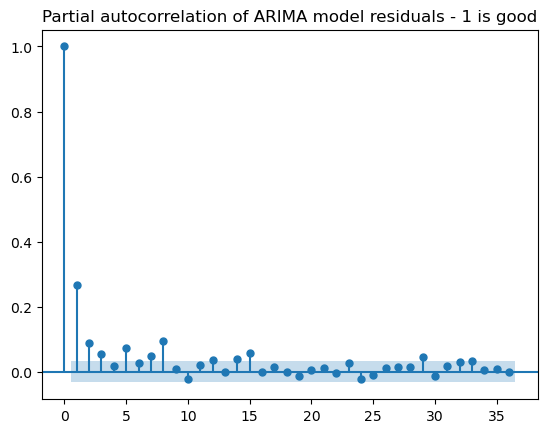

In [19]:
arima_resid = model_fit.resid
plot_pacf(arima_resid**2)
plt.title('Partial autocorrelation of ARIMA model residuals - 1 is good')
plt.show()

In [20]:
for p in p_list:
    for q in q_list:
        history = btc_train_log.to_list()
        predictions = []
        for t in range(len(btc_test_log)):
            model = arima_model.ARIMA(history, order=(p, 1, q))
            model_fit = model.fit()
            arima_predict = model_fit.forecast()[0]
                
            garch = arch_model(model_fit.resid, p=1, q=1)
            garch_fit = garch.fit(disp='off', show_warning=False)
            garch_pred = garch_fit.forecast(horizon=1).mean.iloc[-1]['h.1']    
    
            prediction = arima_predict + garch_pred
                
            history.append(btc_test_log[t])
            predictions.append(prediction)

        predictions = pd.Series(predictions, index=btc_test_log.index, name='Holt_Winter')
        RMSE1 = mean_squared_error(btc_test_log, predictions, squared=False)
        print(f'ARIMA + GARCH(1,1) model parameters {p=}, {q=} the RMSE is ', np.around(RMSE1, 6))

ARIMA + GARCH(1,1) model parameters p=0, q=0 the RMSE is  0.024862
ARIMA + GARCH(1,1) model parameters p=0, q=1 the RMSE is  0.024974
ARIMA + GARCH(1,1) model parameters p=0, q=2 the RMSE is  0.025069
ARIMA + GARCH(1,1) model parameters p=1, q=0 the RMSE is  0.02495
ARIMA + GARCH(1,1) model parameters p=1, q=1 the RMSE is  0.025027
ARIMA + GARCH(1,1) model parameters p=1, q=2 the RMSE is  0.025068
ARIMA + GARCH(1,1) model parameters p=2, q=0 the RMSE is  0.02507
ARIMA + GARCH(1,1) model parameters p=2, q=1 the RMSE is  0.025081
ARIMA + GARCH(1,1) model parameters p=2, q=2 the RMSE is  0.025099


- ARIMA + GARCH(1,1) model parameters p=0, q=0 the RMSE is  0.024862
- ARIMA + GARCH(1,1) model parameters p=0, q=1 the RMSE is  0.024974
- ARIMA + GARCH(1,1) model parameters p=0, q=2 the RMSE is  0.025069
- ARIMA + GARCH(1,1) model parameters p=1, q=0 the RMSE is  0.02495
- ARIMA + GARCH(1,1) model parameters p=1, q=1 the RMSE is  0.025027
- ARIMA + GARCH(1,1) model parameters p=1, q=2 the RMSE is  0.025068
- ARIMA + GARCH(1,1) model parameters p=2, q=0 the RMSE is  0.02507
- ARIMA + GARCH(1,1) model parameters p=2, q=1 the RMSE is  0.025081
- ARIMA + GARCH(1,1) model parameters p=2, q=2 the RMSE is  0.025099

GARCH added to ARIMA reduced somewhat RMSE, but stll did not bit random walk base model.

#### Exponential Smoothing model

In [21]:
#List of hyperparameters for exponential smoothing model
trend_list = [None, 'add', 'mul']
seasonal_list = [None, 'add', 'mul']
seasonal_period_list = [2, 3, 4] #must be >1

In [22]:
for trend in trend_list:
    for seasonal in seasonal_list:
        for per in seasonal_period_list:
            if seasonal == None:
                period = None
            else:
                 period =  per

            history = btc_train_log.to_list()
            predictions = []
            for t in range(len(btc_test_log)):
                model = ExponentialSmoothing(np.asarray(history), seasonal_periods=period, trend=trend, seasonal=seasonal)
                model_fit = model.fit(optimized=True)
                prediction = model_fit.forecast(1)[0]
                history.append(btc_test_log[t])
                predictions.append(prediction)

            predictions = pd.Series(predictions, index=btc_test_log.index, name='Exponenetial smoothing')
            RMSE1 = mean_squared_error(btc_test_log, predictions, squared=False)
            print(f'Exponential smoothing model parameters trend={trend}, seasonal={seasonal}, seasonal_period={period} the RMSE is ', np.around(RMSE1, 6))
            if seasonal==None:
                break                

Exponential smoothing model parameters trend=None, seasonal=None, seasonal_period=None the RMSE is  0.024847
Exponential smoothing model parameters trend=None, seasonal=add, seasonal_period=2 the RMSE is  0.024809
Exponential smoothing model parameters trend=None, seasonal=add, seasonal_period=3 the RMSE is  0.024844
Exponential smoothing model parameters trend=None, seasonal=add, seasonal_period=4 the RMSE is  0.024969
Exponential smoothing model parameters trend=None, seasonal=mul, seasonal_period=2 the RMSE is  0.024809
Exponential smoothing model parameters trend=None, seasonal=mul, seasonal_period=3 the RMSE is  0.024847
Exponential smoothing model parameters trend=None, seasonal=mul, seasonal_period=4 the RMSE is  0.025018
Exponential smoothing model parameters trend=add, seasonal=None, seasonal_period=None the RMSE is  0.024868
Exponential smoothing model parameters trend=add, seasonal=add, seasonal_period=2 the RMSE is  0.024829
Exponential smoothing model parameters trend=add,

- Exponential smoothing model parameters trend=None, seasonal=None, seasonal_period=None the RMSE is  0.024847
- __Exponential smoothing model parameters trend=None, seasonal=add, seasonal_period=2 the RMSE is  0.024809__
- Exponential smoothing model parameters trend=None, seasonal=add, seasonal_period=3 the RMSE is  0.024844
- Exponential smoothing model parameters trend=None, seasonal=add, seasonal_period=4 the RMSE is  0.024969
- __Exponential smoothing model parameters trend=None, seasonal=mul, seasonal_period=2 the RMSE is  0.024809__
- Exponential smoothing model parameters trend=None, seasonal=mul, seasonal_period=3 the RMSE is  0.024847
- Exponential smoothing model parameters trend=None, seasonal=mul, seasonal_period=4 the RMSE is  0.025018
- Exponential smoothing model parameters trend=add, seasonal=None, seasonal_period=None the RMSE is  0.024868
- Exponential smoothing model parameters trend=add, seasonal=add, seasonal_period=2 the RMSE is  0.024829
- Exponential smoothing model parameters trend=add, seasonal=add, seasonal_period=3 the RMSE is  0.024866
- Exponential smoothing model parameters trend=add, seasonal=add, seasonal_period=4 the RMSE is  0.024968
- Exponential smoothing model parameters trend=add, seasonal=mul, seasonal_period=2 the RMSE is  0.02484
- Exponential smoothing model parameters trend=add, seasonal=mul, seasonal_period=3 the RMSE is  0.024873
- Exponential smoothing model parameters trend=add, seasonal=mul, seasonal_period=4 the RMSE is  0.025045
- Exponential smoothing model parameters trend=mul, seasonal=None, seasonal_period=None the RMSE is  0.024882
- Exponential smoothing model parameters trend=mul, seasonal=add, seasonal_period=2 the RMSE is  0.024837
- Exponential smoothing model parameters trend=mul, seasonal=add, seasonal_period=3 the RMSE is  0.024882
- Exponential smoothing model parameters trend=mul, seasonal=add, seasonal_period=4 the RMSE is  0.024997
- Exponential smoothing model parameters trend=mul, seasonal=mul, seasonal_period=2 the RMSE is  0.024846
- Exponential smoothing model parameters trend=mul, seasonal=mul, seasonal_period=3 the RMSE is  0.024865
- Exponential smoothing model parameters trend=mul, seasonal=mul, seasonal_period=4 the RMSE is  0.025055

__Best__ Model parameters:
- trend = None, seasonal = add, seasonal_period = 2
- trend = None, seasonal = mul, seasonal_period = 2 

the RMSE is  0.024809

#### GARCH model added to Exponential smoothing

In [23]:
history = btc_train_log.to_list()
predictions = []
for t in range(len(btc_test_log)):
    model = ExponentialSmoothing(np.asarray(history), seasonal_periods=2, trend=None, seasonal='add')
    model_fit = model.fit(optimized=True)
    prediction = model_fit.forecast(1)[0]
    history.append(btc_test_log[t])
    predictions.append(prediction)

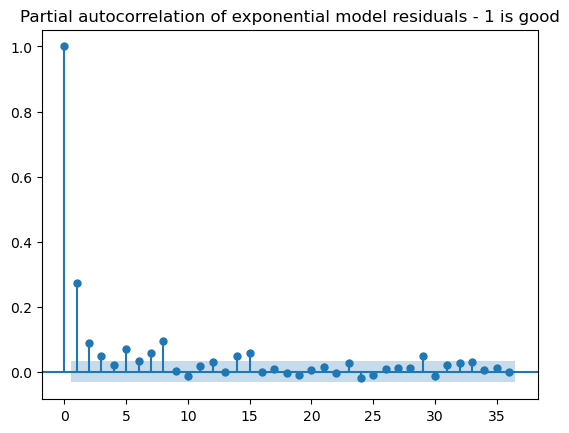

In [24]:
exp_resid = model_fit.resid
plot_pacf(exp_resid**2)
plt.title('Partial autocorrelation of exponential model residuals - 1 is good')
plt.show()

In [25]:
#Exponential smoothing + GARCH 

for trend in trend_list:
    for seasonal in seasonal_list:
        for per in seasonal_period_list:
            if seasonal == None:
                period = None
            else:
                 period =  per

            history = btc_train_log.to_list()
            predictions = []
            for t in range(len(btc_test_log)):
                model = ExponentialSmoothing(np.asarray(history), seasonal_periods=period, trend=trend, seasonal=seasonal)
                model_fit = model.fit(optimized=True)
                exp_pred = model_fit.forecast(1)[0]
                
                garch = arch_model(model_fit.resid, p=1, q=1)
                garch_fit = garch.fit(disp='off', show_warning=False)
                garch_pred = garch_fit.forecast(horizon=1).mean.iloc[-1]['h.1']    
    
                prediction = exp_pred + garch_pred
                
                history.append(btc_test_log[t])
                predictions.append(prediction)

            predictions = pd.Series(predictions, index=btc_test_log.index, name='Holt_Winter')
            RMSE1 = mean_squared_error(btc_test_log, predictions, squared=False)
            print(f'Exp. smoothing + GARCH(1,1) model parameters trend={trend}, seasonal={seasonal}, seasonal_period={period} the RMSE is ', np.around(RMSE1, 6))
            if seasonal==None:
                break

Exp. smoothing + GARCH(1,1) model parameters trend=None, seasonal=None, seasonal_period=None the RMSE is  0.024861
Exp. smoothing + GARCH(1,1) model parameters trend=None, seasonal=add, seasonal_period=2 the RMSE is  0.024823
Exp. smoothing + GARCH(1,1) model parameters trend=None, seasonal=add, seasonal_period=3 the RMSE is  0.024858
Exp. smoothing + GARCH(1,1) model parameters trend=None, seasonal=add, seasonal_period=4 the RMSE is  0.024985
Exp. smoothing + GARCH(1,1) model parameters trend=None, seasonal=mul, seasonal_period=2 the RMSE is  0.024819
Exp. smoothing + GARCH(1,1) model parameters trend=None, seasonal=mul, seasonal_period=3 the RMSE is  0.024861
Exp. smoothing + GARCH(1,1) model parameters trend=None, seasonal=mul, seasonal_period=4 the RMSE is  0.025034
Exp. smoothing + GARCH(1,1) model parameters trend=add, seasonal=None, seasonal_period=None the RMSE is  0.02486
Exp. smoothing + GARCH(1,1) model parameters trend=add, seasonal=add, seasonal_period=2 the RMSE is  0.024

- Exp. smoothing + GARCH(1,1) model parameters trend=None, seasonal=None, seasonal_period=None the RMSE is  0.024861
- Exp. smoothing + GARCH(1,1) model parameters trend=None, seasonal=add, seasonal_period=2 the RMSE is  0.024823
- Exp. smoothing + GARCH(1,1) model parameters trend=None, seasonal=add, seasonal_period=3 the RMSE is  0.024858
- Exp. smoothing + GARCH(1,1) model parameters trend=None, seasonal=add, seasonal_period=4 the RMSE is  0.024985
- Exp. smoothing + GARCH(1,1) model parameters trend=None, seasonal=mul, seasonal_period=2 the RMSE is  0.024819
- Exp. smoothing + GARCH(1,1) model parameters trend=None, seasonal=mul, seasonal_period=3 the RMSE is  0.024861
- Exp. smoothing + GARCH(1,1) model parameters trend=None, seasonal=mul, seasonal_period=4 the RMSE is  0.025034
- Exp. smoothing + GARCH(1,1) model parameters trend=add, seasonal=None, seasonal_period=None the RMSE is  0.02486
- Exp. smoothing + GARCH(1,1) model parameters trend=add, seasonal=add, seasonal_period=2 the RMSE is  0.024823
- Exp. smoothing + GARCH(1,1) model parameters trend=add, seasonal=add, seasonal_period=3 the RMSE is  0.02486
- Exp. smoothing + GARCH(1,1) model parameters trend=add, seasonal=add, seasonal_period=4 the RMSE is  0.024964
- Exp. smoothing + GARCH(1,1) model parameters trend=add, seasonal=mul, seasonal_period=2 the RMSE is  0.024824
- Exp. smoothing + GARCH(1,1) model parameters trend=add, seasonal=mul, seasonal_period=3 the RMSE is  0.024859
- Exp. smoothing + GARCH(1,1) model parameters trend=add, seasonal=mul, seasonal_period=4 the RMSE is  0.025031
- Exp. smoothing + GARCH(1,1) model parameters trend=mul, seasonal=None, seasonal_period=None the RMSE is  0.024879
- Exp. smoothing + GARCH(1,1) model parameters trend=mul, seasonal=add, seasonal_period=2 the RMSE is  0.024831
- Exp. smoothing + GARCH(1,1) model parameters trend=mul, seasonal=add, seasonal_period=3 the RMSE is  0.02487
- Exp. smoothing + GARCH(1,1) model parameters trend=mul, seasonal=add, seasonal_period=4 the RMSE is  0.02499
- Exp. smoothing + GARCH(1,1) model parameters trend=mul, seasonal=mul, seasonal_period=2 the RMSE is  0.024838
- Exp. smoothing + GARCH(1,1) model parameters trend=mul, seasonal=mul, seasonal_period=3 the RMSE is  0.02486
- Exp. smoothing + GARCH(1,1) model parameters trend=mul, seasonal=mul, seasonal_period=4 the RMSE is  0.025052

Addition of GARCH did not imrove model performance.

Best RMSE is still 0.024809 for Exponential Smoothing only.

### Examinining on different trend periods

#### Diverse period

Period with mixed trends (up and down)

Chose to test for period 1.1.21-1.7.21

In [26]:
diverse_train = df_btc[df_btc.index<'2021-01-01']
diverse_test = df_btc[(df_btc.index>='2021-01-01') & (df_btc.index<='2021-07-01')]
diverse_train_log =np.log(diverse_train)
diverse_test_log =np.log(diverse_test)

In [27]:
#Calculate RMSE for andom walk base model for diverse test period

random_walk_diverse = pd.Series(create_random_walk(diverse_test_log, diverse_train_log), index=diverse_test_log.index, name='random_walk_pred')
RMSE = mean_squared_error(diverse_test_log, random_walk_diverse, squared=False)
print('RMSE of baseline naive model for bitcoin for diverse period ', round(RMSE, 6))

RMSE of baseline naive model for bitcoin for diverse period  0.036098


In [28]:
history = diverse_train_log.to_list()
predictions = []

for t in range(len(diverse_test_log)):
    model = ExponentialSmoothing(np.asarray(history), seasonal_periods=2, trend=None, seasonal='add')
    model_fit = model.fit(optimized=True)
    prediction = model_fit.forecast(1)[0]
    history.append(diverse_test_log[t])
    predictions.append(prediction)
    if t%100==0:
        print(f'Round {t} completed')

diverse_predictions = pd.Series(predictions, index=diverse_test_log.index, name='Holt_Winter')

RMSE = (((diverse_test_log-diverse_predictions)**2).mean())**0.5
print(f'For Holt_Winter model of bitcoin in diverse period the RMSE is ', round(RMSE, 6))

Round 0 completed
Round 100 completed
Round 200 completed
Round 300 completed
For Holt_Winter model of bitcoin in diverse period the RMSE is  0.03612


In [29]:
diverse_labels = pd.concat([diverse_test.to_frame(), diverse_predictions.to_frame()], axis=1)
diverse_labels['Holt_Winter']=np.exp(diverse_labels['Holt_Winter'])
diverse_labels['prev_price'] = diverse_labels['btc_price'].shift(periods=1)
diverse_labels['prev_price'].iloc[0] = diverse_train.iloc[-1]
diverse_labels['ratio_of_predict'] = (diverse_labels['Holt_Winter']-diverse_labels['prev_price'])/diverse_labels['prev_price']

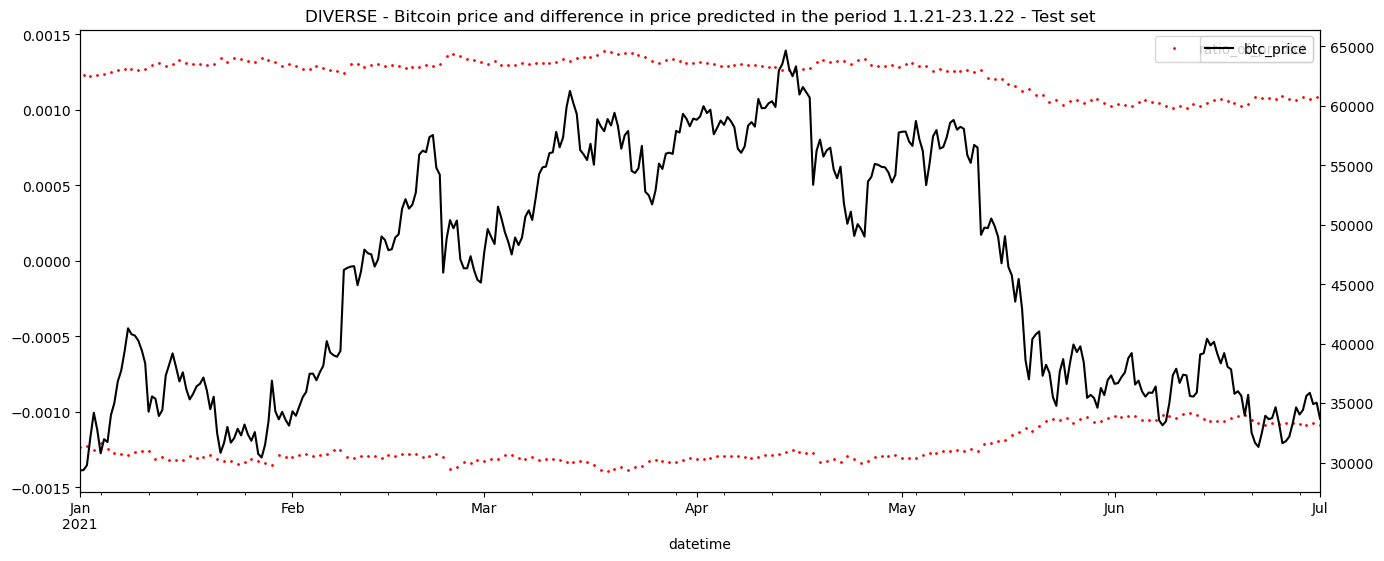

In [30]:
fig, ax1 = plt.subplots(figsize=(16, 6))

diverse_labels['ratio_of_predict'].plot(legend=True, ax=ax1, color='red',  linestyle ='None', marker='o', markersize=1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

diverse_labels['btc_price'].plot(legend=True, ax=ax2, color='black')

plt.title('DIVERSE - Bitcoin price and difference in price predicted in the period 1.1.21-23.1.22 - Test set')
plt.show()

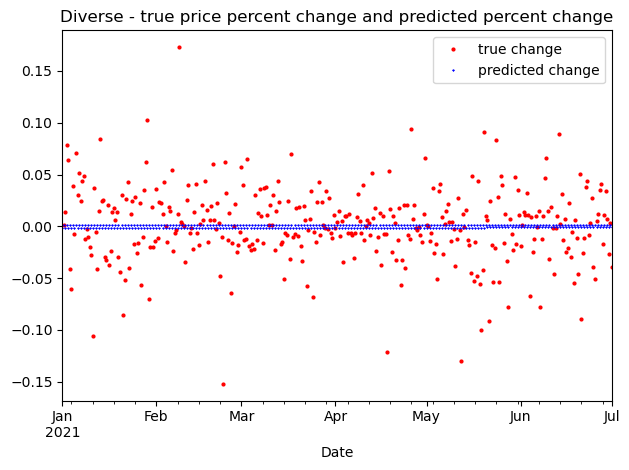

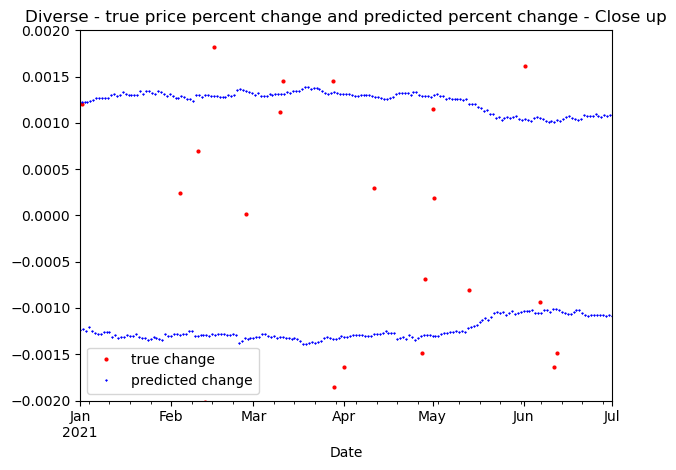

In [31]:
pct_change = diverse_labels['btc_price'].pct_change()
pct_change.plot(legend=True, color='red', linestyle ='None', marker='o', markersize=2, label='true change')
diverse_labels['ratio_of_predict'].plot(legend=True, color='blue', linestyle ='None', marker='*', markersize=1, label='predicted change')
plt.title('Diverse - true price percent change and predicted percent change')
plt.xlabel('Date')

plt.tight_layout()
plt.show()


pct_change = diverse_labels['btc_price'].pct_change()
pct_change.plot(legend=True, color='red', linestyle ='None', marker='o', markersize=2, label='true change')
diverse_labels['ratio_of_predict'].plot(legend=True, color='blue', linestyle ='None', marker='*', markersize=1, label='predicted change')
plt.ylim(-0.002, 0.002)
plt.title('Diverse - true price percent change and predicted percent change - Close up')
plt.xlabel('Date')

plt.tight_layout()
plt.show()

#### Bearish market

Period with downtrend

In [32]:
bearish_train = df_btc[df_btc.index<'2021-03-15']
bearish_test = df_btc[(df_btc.index>='2021-03-15') & (df_btc.index<='2021-07-01')]
bearish_train_log =np.log(bearish_train)
bearish_test_log =np.log(bearish_test)

In [33]:
#Calculate RMSE for andom walk base model for diverse test period

random_walk_bearish = pd.Series(create_random_walk(bearish_test_log, bearish_train_log), index=bearish_test_log.index, name='random_walk_pred')
RMSE = mean_squared_error(bearish_test_log, random_walk_bearish, squared=False)
print('RMSE of baseline naive model for bitcoin for bearish period ', round(RMSE, 6))

RMSE of baseline naive model for bitcoin for bearish period  0.034421


In [34]:
history = bearish_train_log.to_list()
predictions = []

for t in range(len(bearish_test_log)):
    model = ExponentialSmoothing(np.asarray(history), seasonal_periods=2, trend=None, seasonal='add')
    model_fit = model.fit(optimized=True)
    prediction = model_fit.forecast(1)[0]
    history.append(bearish_test_log[t])
    predictions.append(prediction)
    if t%100==0:
        print(f'Round {t} completed')

bearish_predictions = pd.Series(predictions, index=bearish_test_log.index, name='Holt_Winter')

RMSE = (((bearish_test_log - bearish_predictions)**2).mean())**0.5
print(f'For Holt_Winter model of bitcoin in bearish market the RMSE is ', round(RMSE, 6))

Round 0 completed
Round 100 completed
Round 200 completed
For Holt_Winter model of bitcoin in bearish market the RMSE is  0.034515


Model in this case performs worse than random walk

In [35]:
bearish_labels = pd.concat([bearish_test.to_frame(), bearish_predictions.to_frame()], axis=1)
bearish_labels['Holt_Winter']=np.exp(bearish_labels['Holt_Winter'])
bearish_labels['prev_price'] = bearish_labels['btc_price'].shift(periods=1)
bearish_labels['prev_price'].iloc[0] = bearish_train.iloc[-1]
bearish_labels['ratio_of_predict'] = (bearish_labels['Holt_Winter']-bearish_labels['prev_price'])/bearish_labels['prev_price']

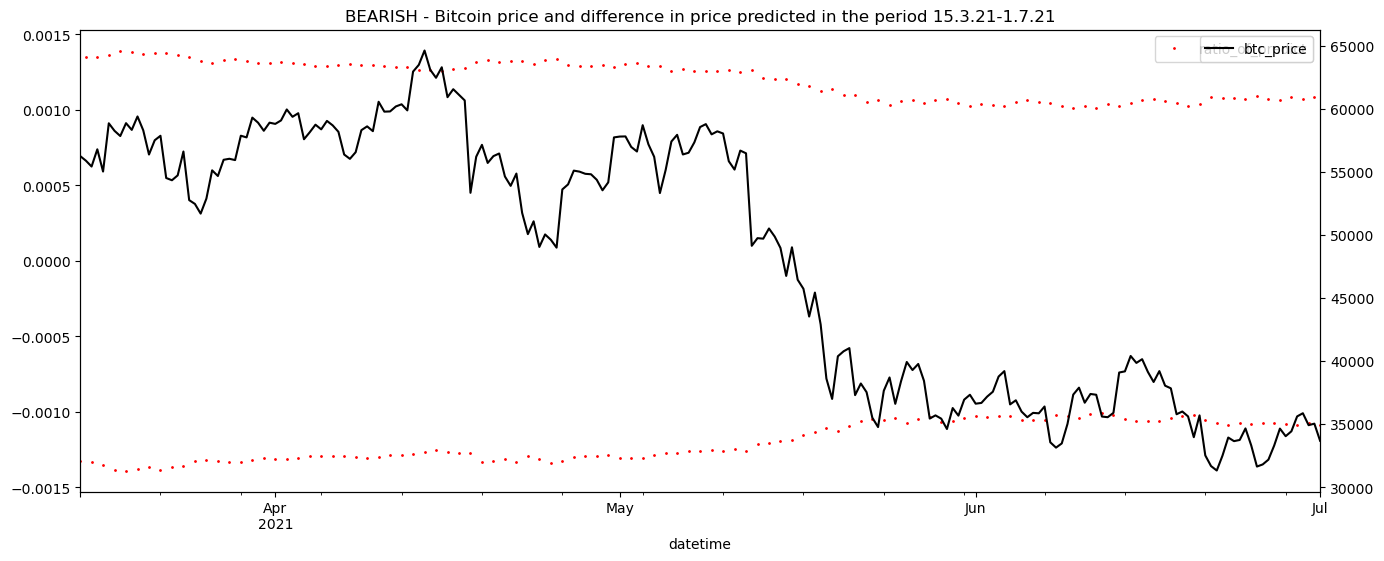

In [36]:
fig, ax1 = plt.subplots(figsize=(16, 6))

bearish_labels['ratio_of_predict'].plot(legend=True, ax=ax1, color='red',linestyle ='None', marker='o', markersize=1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

bearish_labels['btc_price'].plot(legend=True, ax=ax2, color='black')

plt.title('BEARISH - Bitcoin price and difference in price predicted in the period 15.3.21-1.7.21')
plt.show()

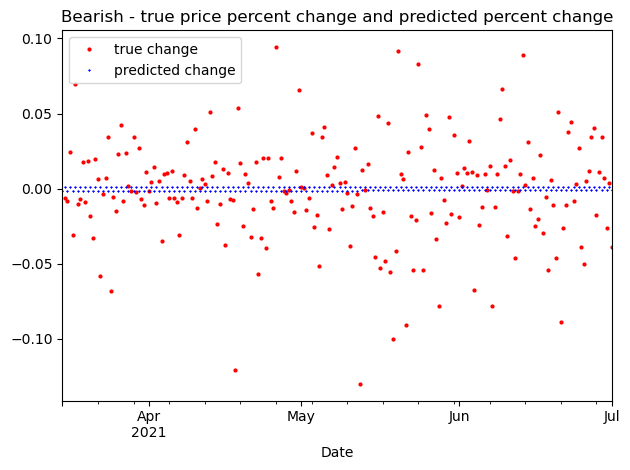

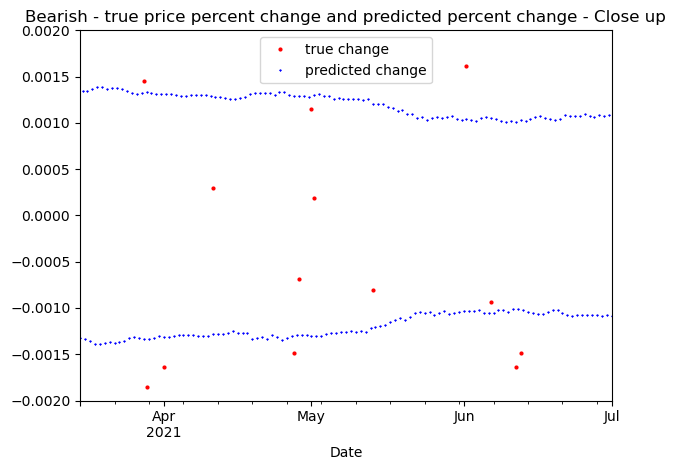

In [37]:
pct_change = bearish_labels['btc_price'].pct_change()
pct_change.plot(legend=True, color='red', linestyle ='None', marker='o', markersize=2, label='true change')
bearish_labels['ratio_of_predict'].plot(legend=True, color='blue', linestyle ='None', marker='*', markersize=1, label='predicted change')
plt.title('Bearish - true price percent change and predicted percent change')
plt.xlabel('Date')

plt.tight_layout()
plt.show()


pct_change = bearish_labels['btc_price'].pct_change()
pct_change.plot(legend=True, color='red', linestyle ='None', marker='o', markersize=2, label='true change')
bearish_labels['ratio_of_predict'].plot(legend=True, color='blue', linestyle ='None', marker='*', markersize=1, label='predicted change')
plt.ylim(-0.002, 0.002)
plt.title('Bearish - true price percent change and predicted percent change - Close up')
plt.xlabel('Date')

plt.tight_layout()
plt.show()

####  Bullish market

Period with uptrend

15.7.21-1.11.21

In [38]:
bullish_train = df_btc[df_btc.index<'2021-07-15']
bullish_test = df_btc[(df_btc.index>='2021-07-15') & (df_btc.index<='2021-11-01')]
bullish_train_log =np.log(bullish_train)
bullish_test_log =np.log(bullish_test)

In [39]:
random_walk_bullish = pd.Series(create_random_walk(bullish_test_log, bullish_train_log), index=bullish_test_log.index, name='random_walk_pred')
RMSE = mean_squared_error(bullish_test_log, random_walk_bullish, squared=False)
print('RMSE of baseline naive model for bitcoin for bullish period ', round(RMSE, 6))

RMSE of baseline naive model for bitcoin for bullish period  0.02601


In [40]:
history = bullish_train_log.to_list()
predictions = []

for t in range(len(bullish_test_log)):
    model = ExponentialSmoothing(np.asarray(history), seasonal_periods=2, trend=None, seasonal='add')
    model_fit = model.fit(optimized=True)
    prediction = model_fit.forecast(1)[0]
    history.append(bullish_test_log[t])
    predictions.append(prediction)
    if t%100==0:
        print(f'Round {t} completed')

bullish_predictions = pd.Series(predictions, index=bullish_test_log.index, name='Holt_Winter')

RMSE = (((bullish_test_log - bullish_predictions)**2).mean())**0.5
print(f'For Holt_Winter model of bitcoin in bullish market the RMSE is ', round(RMSE, 6))

Round 0 completed
Round 100 completed
Round 200 completed
For Holt_Winter model of bitcoin in bullish market the RMSE is  0.025975


The models gives better result than random walk base model in bullish market.

In [41]:
bullish_labels = pd.concat([bullish_test.to_frame(), bullish_predictions.to_frame()], axis=1)
bullish_labels['Holt_Winter'] = np.exp(bullish_labels['Holt_Winter'])
bullish_labels['prev_price'] = bullish_labels['btc_price'].shift(periods=1)
bullish_labels['prev_price'].iloc[0] = bullish_train.iloc[-1]
bullish_labels['ratio_of_predict'] = (bullish_labels['Holt_Winter']-bullish_labels['prev_price'])/bullish_labels['prev_price']

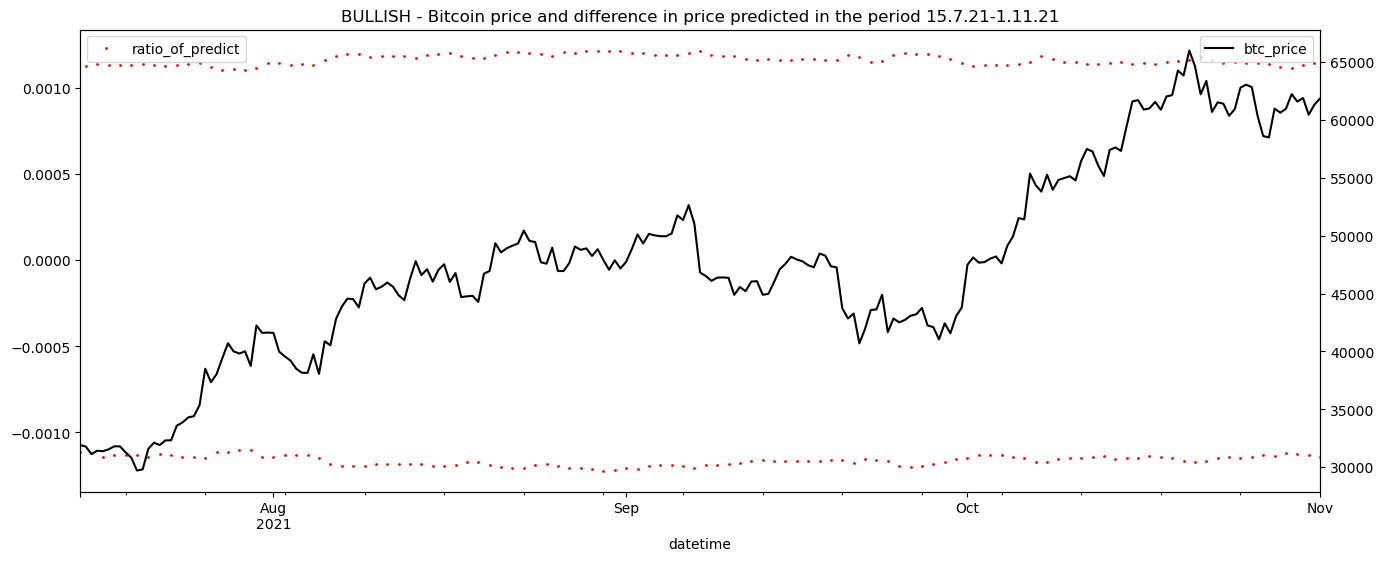

In [42]:
fig, ax1 = plt.subplots(figsize=(16, 6))
bullish_labels['ratio_of_predict'].plot(legend=True, ax=ax1, color='red',linestyle ='None', marker='o', markersize=1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
bullish_labels['btc_price'].plot(legend=True, ax=ax2, color='black')

plt.title('BULLISH - Bitcoin price and difference in price predicted in the period 15.7.21-1.11.21')
plt.show()

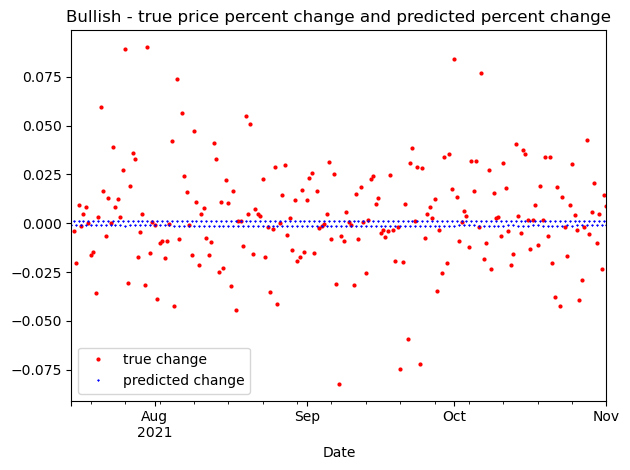

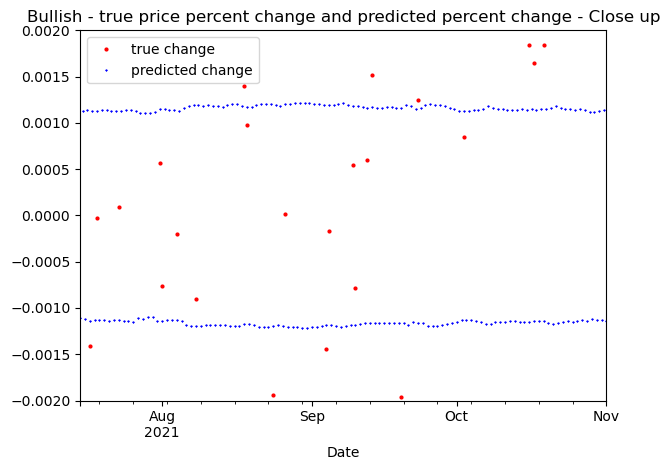

In [43]:
pct_change = bullish_labels['btc_price'].pct_change()
pct_change.plot(legend=True, color='red', linestyle ='None', marker='o', markersize=2, label='true change')
bullish_labels['ratio_of_predict'].plot(legend=True, color='blue', linestyle ='None', marker='*', markersize=1, label='predicted change')
plt.title('Bullish - true price percent change and predicted percent change')
plt.xlabel('Date')
plt.tight_layout()
plt.show()


pct_change = bullish_labels['btc_price'].pct_change()
pct_change.plot(legend=True, color='red', linestyle ='None', marker='o', markersize=2, label='true change')
bullish_labels['ratio_of_predict'].plot(legend=True, color='blue', linestyle ='None', marker='*', markersize=1, label='predicted change')
plt.ylim(-0.002, 0.002)
plt.title('Bullish - true price percent change and predicted percent change - Close up')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

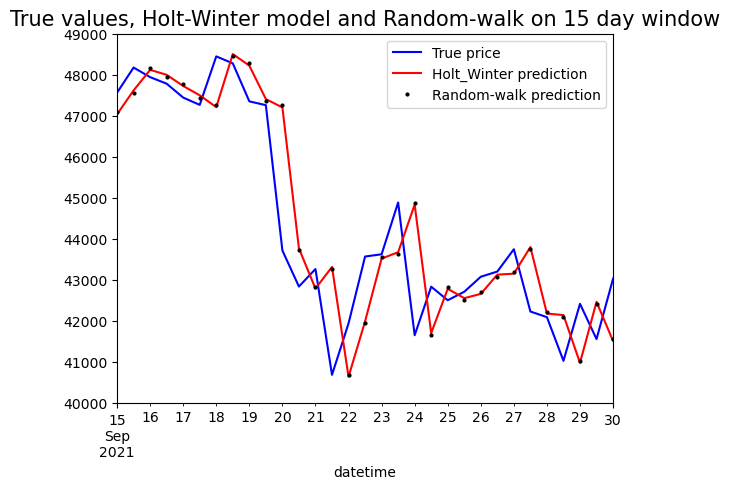

In [44]:
bullish_labels['btc_price'].plot(label='True price', color='blue')
bullish_labels['Holt_Winter'].plot(label='Holt_Winter prediction', color='red')
np.exp(random_walk_bullish).plot(label='Random-walk prediction', color='black', linestyle='None', marker='o', markersize=2)
plt.xlim(pd.Timestamp('2021-09-15'), pd.Timestamp('2021-09-30'))
plt.ylim(40000, 49000)
plt.legend()
plt.title('True values, Holt-Winter model and Random-walk on 15 day window', fontsize=15)
plt.show()

#### Plotting all periods

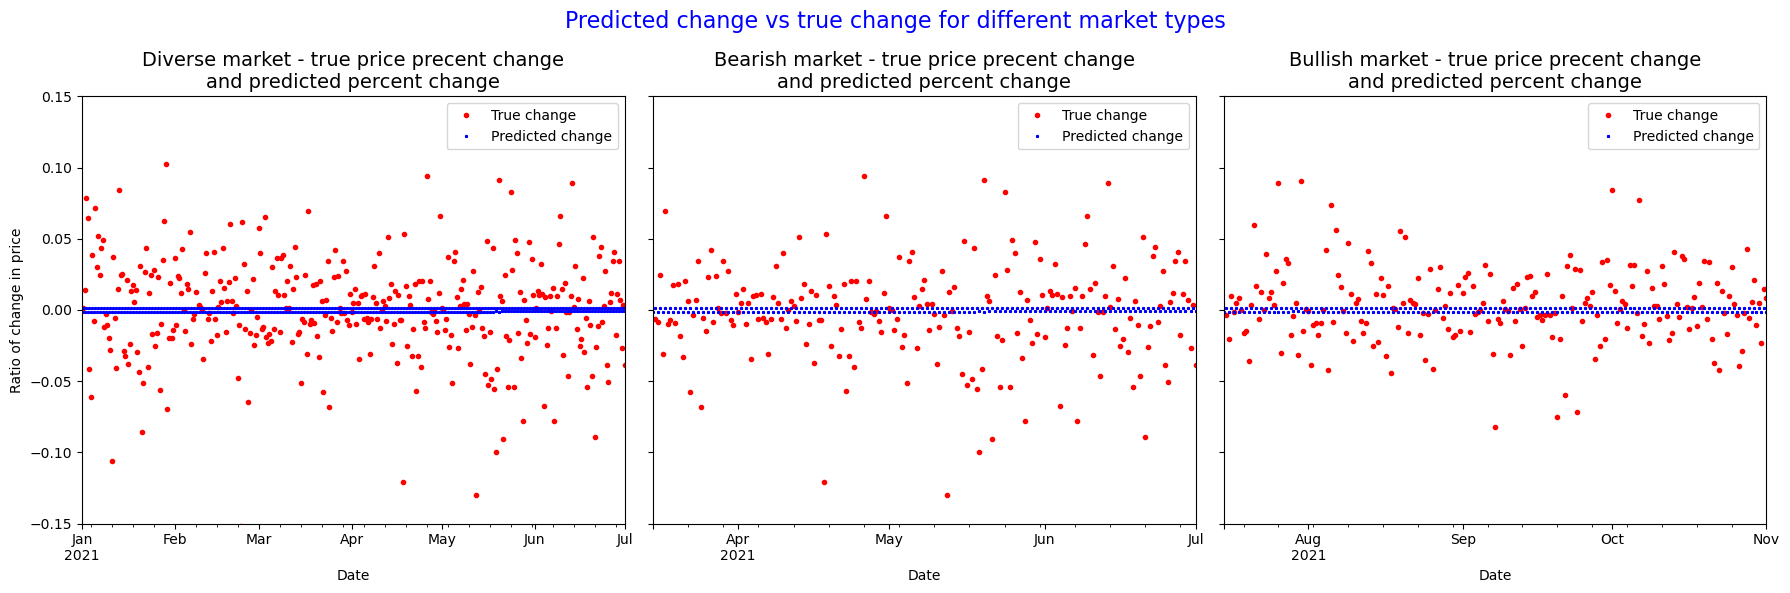

In [45]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(18,6))
fig.suptitle('Predicted change vs true change for different market types', fontsize=16, color='blue')


pct_change_div = diverse_labels['btc_price'].pct_change()
pct_change_div.plot(legend=True, color='red', linestyle ='None', marker='o', markersize=3, ax=ax1, label='True change')
diverse_labels['ratio_of_predict'].plot(legend=True, color='blue', linestyle ='None', marker='*', markersize=2, ax=ax1, label='Predicted change')
ax1.set_title(f'Diverse market - true price precent change\n\
and predicted percent change', fontsize=14)
plt.ylim(-0.15, 0.15)
ax1.set_xlabel('Date')
ax1.set_ylabel('Ratio of change in price')
ax1.legend(loc='upper right')

pct_change_bear = bearish_labels['btc_price'].pct_change()
pct_change_bear.plot(legend=True, color='red', linestyle ='None', marker='o', markersize=3, ax=ax2, label='True change')
bearish_labels['ratio_of_predict'].plot(legend=True, color='blue', linestyle ='None', marker='*', markersize=2, ax=ax2, label='Predicted change')
ax2.set_title(f'Bearish market - true price precent change\n\
and predicted percent change', fontsize=14)
ax2.set_xlabel('Date')

pct_change_bull = bullish_labels['btc_price'].pct_change()
pct_change_bull.plot(legend=True, color='red', linestyle ='None', marker='o', markersize=3, ax=ax3, label='True change')
bullish_labels['ratio_of_predict'].plot(legend=True, color='blue', linestyle ='None', marker='*', markersize=2, ax=ax3, label='Predicted change')
ax3.set_title(f'Bullish market - true price precent change\n\
and predicted percent change', fontsize=14)
ax3.set_xlabel('Date')

plt.tight_layout()
plt.show()

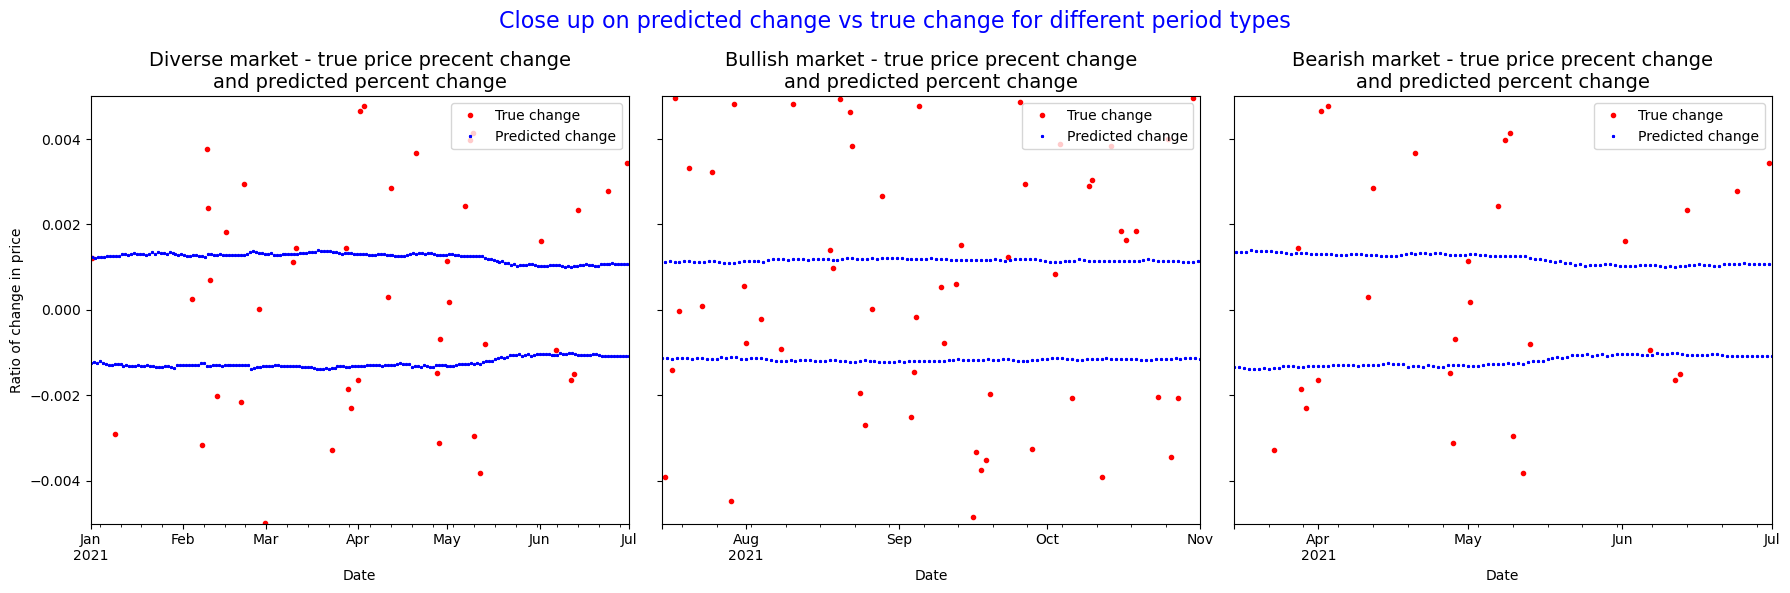

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(18,6))
fig.suptitle('Close up on predicted change vs true change for different period types', fontsize=16, color='blue')


pct_change_div = diverse_labels['btc_price'].pct_change()
pct_change_div.plot(legend=True, color='red', linestyle ='None', marker='o', markersize=3, ax=ax1, label='True change')
diverse_labels['ratio_of_predict'].plot(legend=True, color='blue', linestyle ='None', marker='*', markersize=2, ax=ax1, label='Predicted change')
ax1.set_title(f'Diverse market - true price precent change\n\
and predicted percent change', fontsize=14)
plt.ylim(-0.005, 0.005)
ax1.set_xlabel('Date')
ax1.set_ylabel('Ratio of change in price')
ax1.legend(loc='upper right')

pct_change_bull = bullish_labels['btc_price'].pct_change()
pct_change_bull.plot(legend=True, color='red', linestyle ='None', marker='o', markersize=3, ax=ax2, label='True change')
bullish_labels['ratio_of_predict'].plot(legend=True, color='blue', linestyle ='None', marker='*', markersize=2, ax=ax2, label='Predicted change')
ax2.set_title(f'Bullish market - true price precent change\n\
and predicted percent change', fontsize=14)
ax2.set_xlabel('Date')
ax2.legend(loc='upper right')

pct_change_bear = bearish_labels['btc_price'].pct_change()
pct_change_bear.plot(legend=True, color='red', linestyle ='None', marker='o', markersize=3, ax=ax3, label='True change')
bearish_labels['ratio_of_predict'].plot(legend=True, color='blue', linestyle ='None', marker='*', markersize=2, ax=ax3, label='Predicted change')
ax3.set_title(f'Bearish market - true price precent change\n\
and predicted percent change', fontsize=14)
ax3.set_xlabel('Date')

plt.tight_layout()
plt.show()

## Exploration of data (excluding bitcoin)

for other coins modeling was not done. 

Below in exploratory analysis for dogecoin, litecoin and ethereum

### Doge Coin

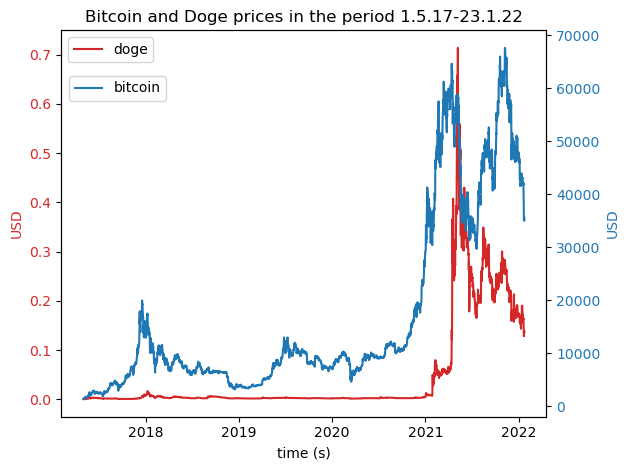

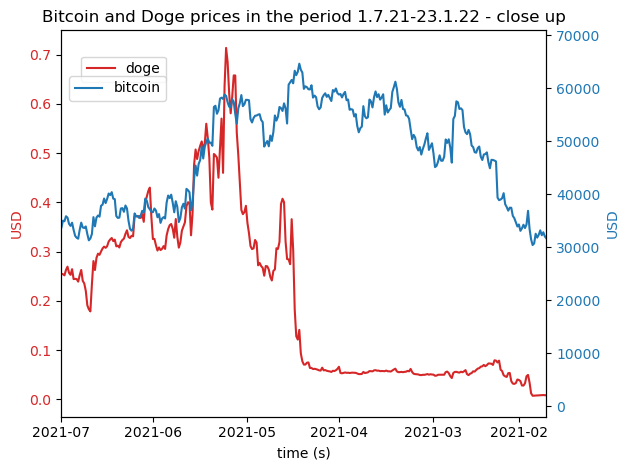

In [47]:
#Plot Doge vs Bitcoin

#1. Complete period
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('USD', color=color)
ax1.plot(df.index, df['doge_price'], color=color, label='doge')
ax1.tick_params(axis='y', labelcolor=color)
plt.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('USD', color=color)  # we already handled the x-label with ax1
ax2.plot(df.index,df['btc_price'], color=color, label='bitcoin')
ax2.tick_params(axis='y', labelcolor=color)
plt.legend(bbox_to_anchor=(0.23, 0.9))

plt.title('Bitcoin and Doge prices in the period 1.5.17-23.1.22')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


#2. Close up on part of the period
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('USD', color=color)
ax1.set_xlim(pd.Timestamp('2021-07-01'), pd.Timestamp('2021-01-23'))
ax1.plot(df.index, df['doge_price'], color=color, label='doge')
ax1.tick_params(axis='y', labelcolor=color)
plt.legend(bbox_to_anchor=(0.23, 0.95))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('USD', color=color)  # we already handled the x-label with ax1
ax2.plot(df.index,df['btc_price'], color=color, label='bitcoin')
ax2.tick_params(axis='y', labelcolor=color)
plt.legend(bbox_to_anchor=(0.23, 0.9))

plt.title('Bitcoin and Doge prices in the period 1.7.21-23.1.22 - close up')
fig.tight_layout()  
plt.show()

In [48]:
df_doge = df['doge_price']
display(df_doge.isnull().sum())

0

In [49]:
df_doge.idxmax(), df_doge.max()

(Timestamp('2021-05-08 00:00:00+0000', tz='UTC'), 0.71352057)

The price of Doge coin reached maximum on 08-May-21 and its value was 0.714

In [50]:
print(f'Doge price increased by {round((df["doge_price"].iloc[-1])/(df["doge_price"].iloc[0]), 1)} times')

Doge price increased by 185.1 times


Clear jump in value from Jan 2021, reaching its peak in 8-May-21 and significantly decreased till now. 

Probably caused by PR done by Elon Mask.

From May 2017 to Jan 2022 the proves increased by 185 times.

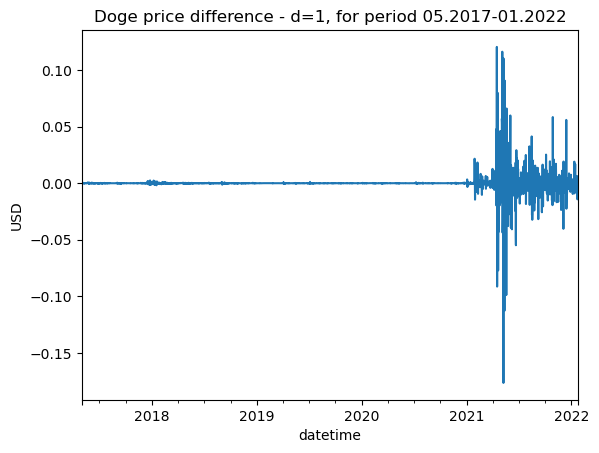

In [51]:
df_doge.diff().plot()
plt.title('Doge price difference - d=1, for period 05.2017-01.2022')
plt.ylabel('USD')
plt.show()

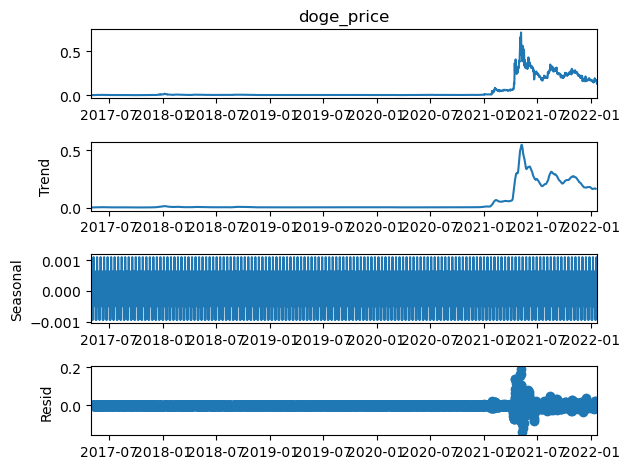

In [52]:
result = sm.tsa.stattools.adfuller(df_doge)
sm.tsa.seasonal_decompose(df_doge).plot()

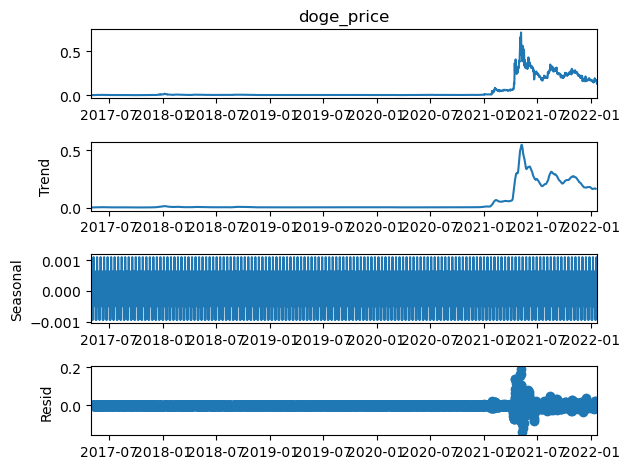

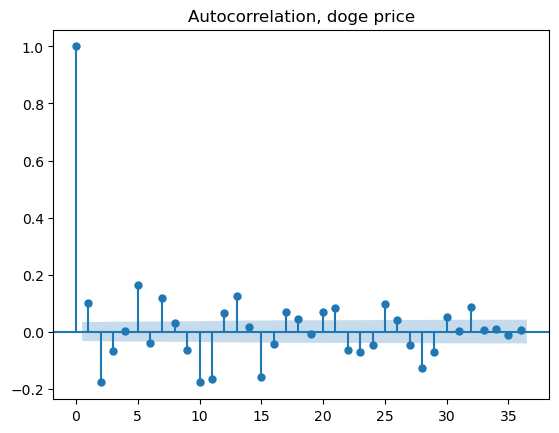

In [53]:
plot_acf(df_doge.diff().dropna())
plt.title('Autocorrelation, doge price')
plt.show()

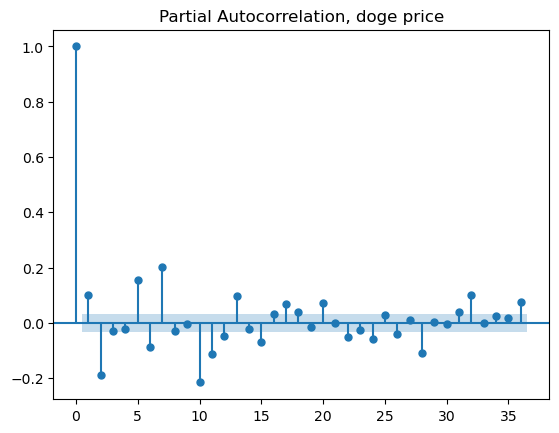

In [54]:
plot_pacf(df_doge.diff().dropna())
plt.title('Partial Autocorrelation, doge price')
plt.show()

### Ethereum

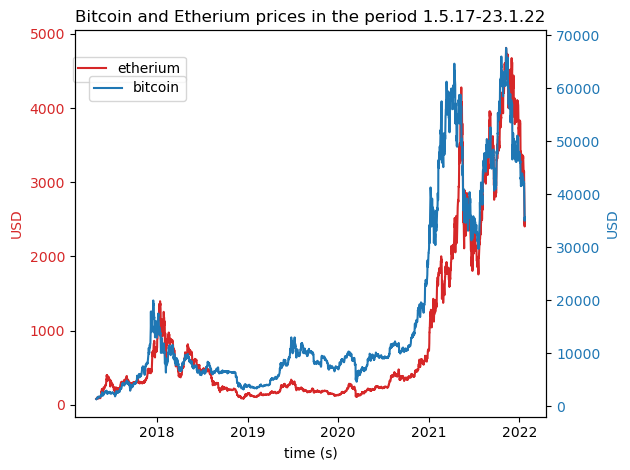

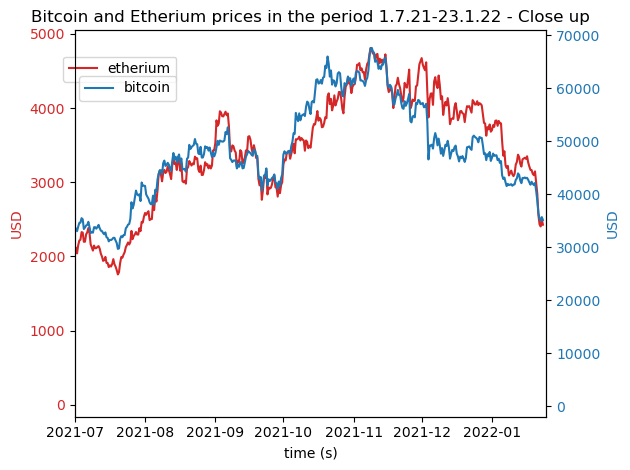

In [55]:
#2. Complete period
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('USD', color=color)
ax1.plot(df.index, df['eth_price'], color=color, label='etherium')
ax1.tick_params(axis='y', labelcolor=color)
plt.legend(bbox_to_anchor=(0.25, 0.95))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('USD', color=color)  # we already handled the x-label with ax1
ax2.plot(df.index,df['btc_price'], color=color, label='bitcoin')
ax2.tick_params(axis='y', labelcolor=color)
plt.legend(bbox_to_anchor=(0.25, 0.9))

plt.title('Bitcoin and Etherium prices in the period 1.5.17-23.1.22')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


#2. Close up on part of the period
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('USD', color=color)
ax1.set_xlim(pd.Timestamp('2021-07-01'), pd.Timestamp('2022-01-25'))
ax1.plot(df.index, df['eth_price'], color=color, label='etherium')
ax1.tick_params(axis='y', labelcolor=color)
plt.legend(bbox_to_anchor=(0.23, 0.95))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('USD', color=color)  # we already handled the x-label with ax1
ax2.plot(df.index, df['btc_price'], color=color, label='bitcoin')
ax2.tick_params(axis='y', labelcolor=color)
plt.legend(bbox_to_anchor=(0.23, 0.9))

plt.title('Bitcoin and Etherium prices in the period 1.7.21-23.1.22 - Close up')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [56]:
df_eth = df['eth_price']
display(df_eth.isnull().sum())

0

In [57]:
df_eth.idxmax(), df_eth.max()

(Timestamp('2021-11-08 12:00:00+0000', tz='UTC'), 4812.087614)

The price of Ethereum coin reached maximum on 08-Nov-21 and its value was 4812$

In [58]:
print(f"Ethereum price increased by {round(df['eth_price'][-1]/df['eth_price'][1], 1)} times")

Ethereum price increased by 31.8 times


Overall trend of prove increase especially from end of 2020, reaching its peak in 08-Nov-21 with some decrease till now. 

From May 2017 to Jan 2022 the price increased by 31.8 times.

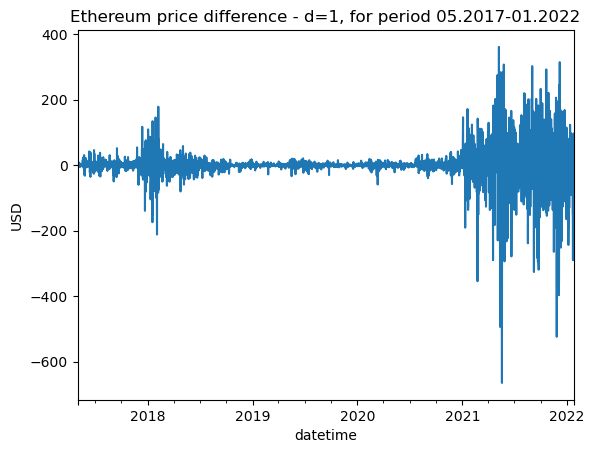

In [59]:
df_eth.diff().plot()
plt.title('Ethereum price difference - d=1, for period 05.2017-01.2022')
plt.ylabel('USD')
plt.show()

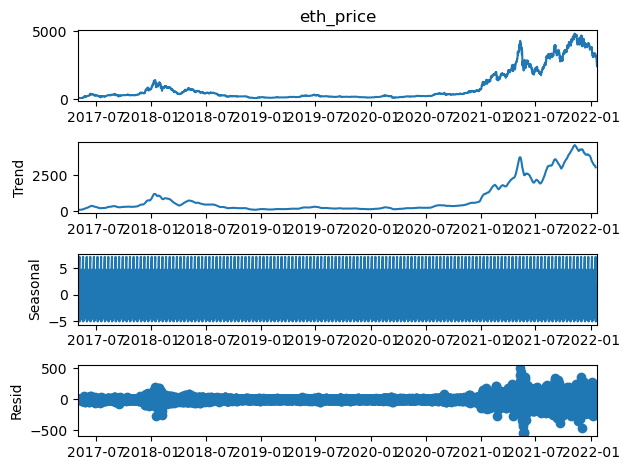

In [60]:
result = sm.tsa.stattools.adfuller(df_eth)
sm.tsa.seasonal_decompose(df_eth).plot()

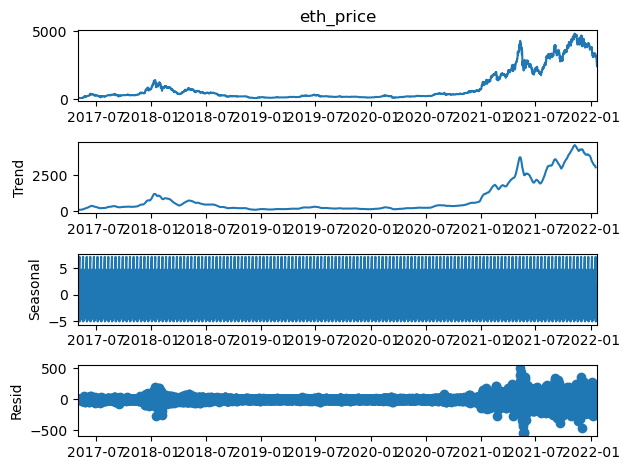

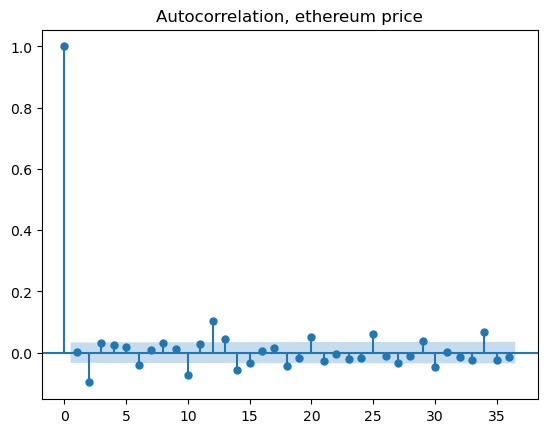

In [61]:
plot_acf(df_eth.diff().dropna())
plt.title('Autocorrelation, ethereum price')
plt.show()

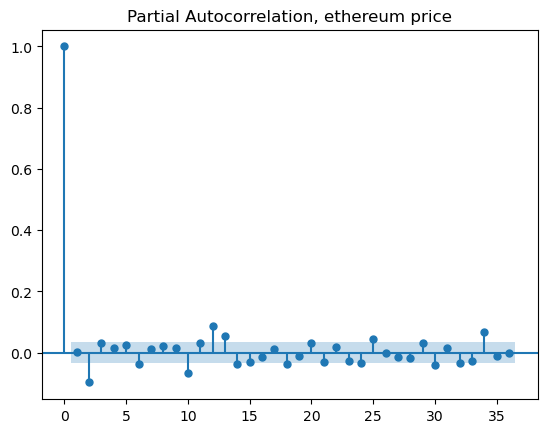

In [62]:
plot_pacf(df_eth.diff().dropna())
plt.title('Partial Autocorrelation, ethereum price')
plt.show()

### Lite coin

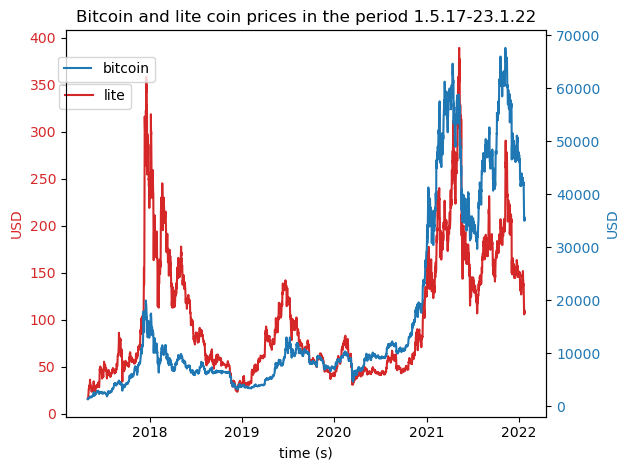

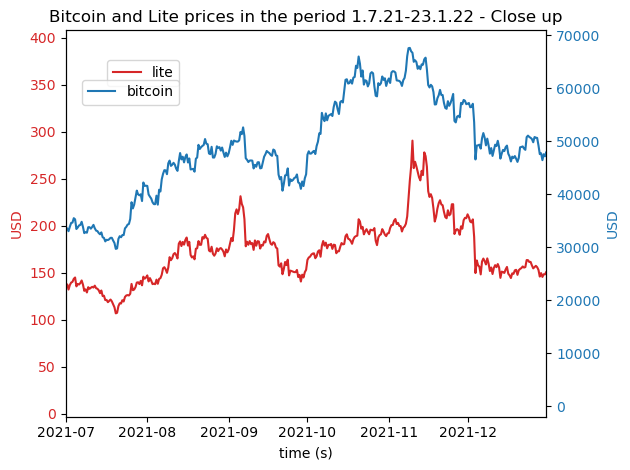

In [63]:
#1. Complete period
fig, ax1 = plt.subplots()


color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('USD', color=color)
ax1.plot(df.index, df['lite_price'], color=color, label='lite')
ax1.tick_params(axis='y', labelcolor=color)
plt.legend(bbox_to_anchor=(0.15, 0.88))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('USD', color=color)  # we already handled the x-label with ax1
ax2.plot(df.index,df['btc_price'], color=color, label='bitcoin')
ax2.tick_params(axis='y', labelcolor=color)
plt.legend(bbox_to_anchor=(0.2, 0.95))

plt.title('Bitcoin and lite coin prices in the period 1.5.17-23.1.22')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#2. Part of period - Close up
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('USD', color=color)
ax1.set_xlim(pd.Timestamp('2021-07-01'), pd.Timestamp('2021-12-31'))
ax1.plot(df.index, df['lite_price'], color=color, label='lite')
ax1.tick_params(axis='y', labelcolor=color)
plt.legend(bbox_to_anchor=(0.25, 0.94))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('USD', color=color)  # we already handled the x-label with ax1
ax2.plot(df.index,df['btc_price'], color=color, label='bitcoin')
ax2.tick_params(axis='y', labelcolor=color)
plt.legend(bbox_to_anchor=(0.25, 0.89))

plt.title('Bitcoin and Lite prices in the period 1.7.21-23.1.22 - Close up')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [64]:
df_lite = df['lite_price']
display(df_lite.isnull().sum())

0

In [65]:
df_lite.idxmax(), df_lite.max()

(Timestamp('2021-05-10 00:00:00+0000', tz='UTC'), 389.1196228)

The price of Lite coin reached maximum on 10-May-21 and its value was 389$

In [66]:
print(f"Lite coin price increased by {round(df['lite_price'][-1]/df['lite_price'][0],1)} times")

Lite coin price increased by 6.6 times


Clear trend up from Oct 2020. Price raised from 05-2017 by 7 times.
Max price reached in 10-May-2021.

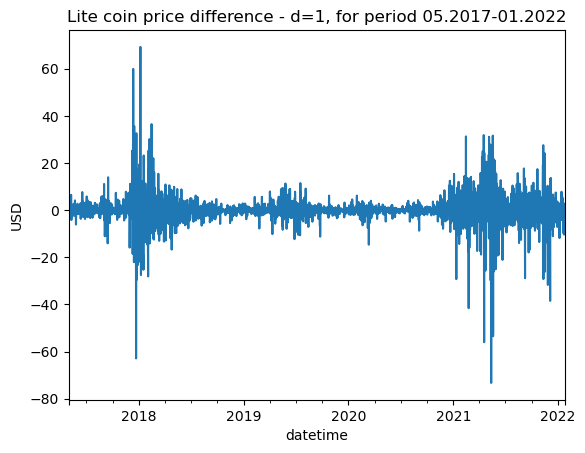

In [67]:
df_lite.diff().plot()
plt.title('Lite coin price difference - d=1, for period 05.2017-01.2022')
plt.ylabel('USD')
plt.show()

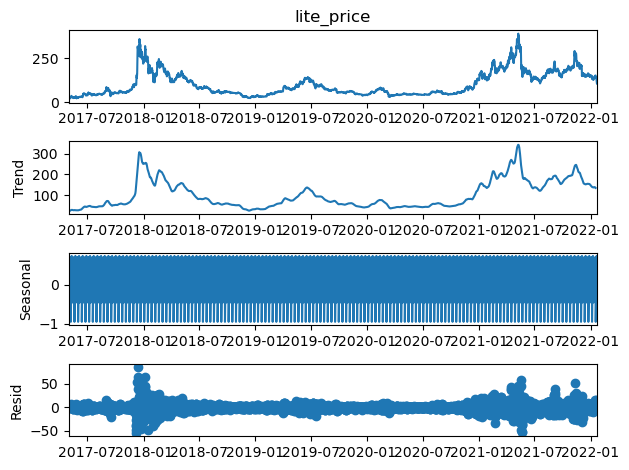

In [68]:
result = sm.tsa.stattools.adfuller(df_lite)
sm.tsa.seasonal_decompose(df_lite).plot()

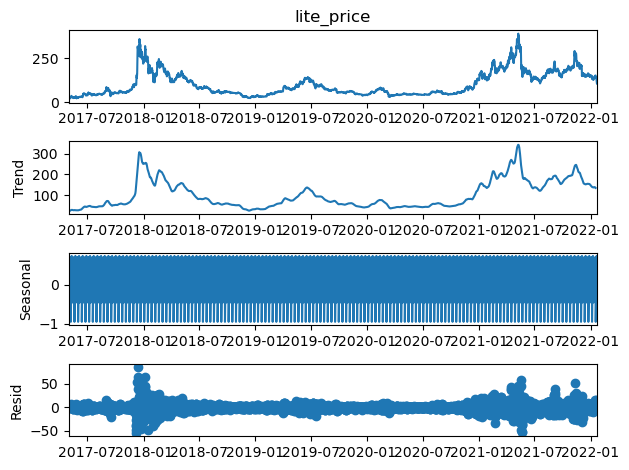

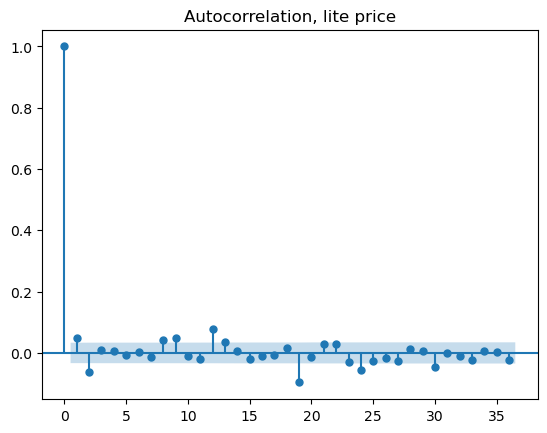

In [69]:
plot_acf(df_lite.diff().dropna())
plt.title('Autocorrelation, lite price')
plt.show()

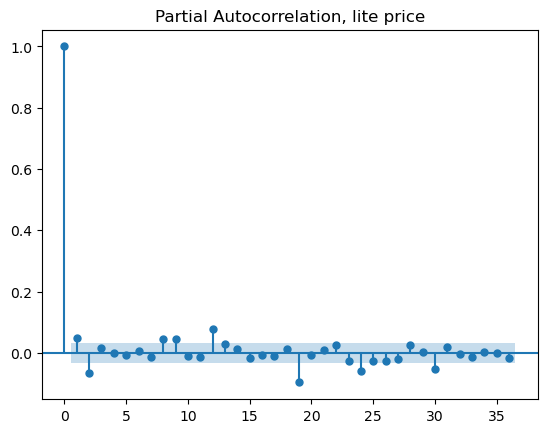

In [70]:
plot_pacf(df_lite.diff().dropna())
plt.title('Partial Autocorrelation, lite price')
plt.show()